# Mejorando el algoritmo de Deutsch-Jozsa

En la sesion anterior exploramos a detalle el algoritmo de Deutsch-Jozsa. Dicho algoritmo nos demuestra como un algoritmo cuantico tiene la posibilidad de ser exponencialmente mas rapido que un algoritmo clasico.

Esencialmente, el algoritmo ejecuta una sola evaluacion para determinar si una funcion es de tipo balanceada o constante. Sin embargo, el algoritmo tiene algunas desventajas. Por ejemplo:

- El oraculo es completamente diferente para el caso de una funcion balanceada o constante.

- Necesitamos mas de un cubit para evaluar la funcion.

A continuacion, se presenta una alternativa en la que no necesitamos decidir en el tipo de oraculo que vamos a utilizar.

In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import Aer, execute
from qiskit.visualization import plot_histogram

TOSSES = 3

Ahora, crearemos un oraculo generalizado, que toma como entrada dos registros cuanticos y el parametro de configuracion, *config* que contiene una cadena de caracteres consistente de 0s y 1s. Cada digito representa el resultado de la evaluacion de la funcion que pretendemos clasificar.

Es decir, si la cadena contiene tres 0s o tres 1s, la funcion es de tipo constante. En el caso de no ser asi, la funcion debe de ser de tipo balanceada.

In [2]:
def oracle(qr, aux, config):
    # Empezamos por crear un sub-circuito
    oc = QuantumCircuit(qr, aux)

    for pos in range(len(config)):
        if config[pos] == '1':
            oc.cx(qr[pos], aux)
    
    # La funcion regresa el oraculo como compuerta
    oracle = oc.to_gate()
    oracle.name = "oracle"
    return oracle

Dentro de la funcion *oraculo*, evaluamos cada posicion de la cadena de caracteres *config*. Cada vex que uno de los bits en esta cadena es igual a 1, aplicamos la compuerta de *CNOT* donde el target es el cubit auxiliar. El circuito cuantico completo es el siguiente:

In [3]:
def create_circuit(config):
    qr = QuantumRegister(TOSSES, "toss")
    aux = QuantumRegister(1, "aux")
    cr = ClassicalRegister(1, "cr")
    qc = QuantumCircuit(qr, aux)

    # El cubit auxiliar lo rotamos al estado |->
    qc.x(aux)
    qc.h(aux)

    # Los cubits asociados a la variable X los rotamos al estado |+>
    qc.h(qr)

    # Aplicamos el oraculo
    qc. append(oracle(qr, aux, config), [*qr, *aux])

    # Sacamos a los cubits de la superposicion
    qc.h(qr)
    qc.h(aux)
    qc.barrier()

    # Regresamos al cubit ancilla al estado |0>
    qc.x(aux)

    # Cambiamos el cubit ancilla a |1> si todos los cubits asociados a X estan en |1>
    qc.mcx(qr, aux)

    qc.x(qr)
    qc.mcx(qr, aux)
    qc.x(qr)

    return qc

In [4]:
qc = create_circuit('000')

In [5]:
qc.draw()

┌───┐     ┌─────────┐┌───┐ ░           ┌───┐     ┌───┐
toss_0: ┤ H ├─────┤0        ├┤ H ├─░────────■──┤ X ├──■──┤ X ├
        ├───┤     │         │├───┤ ░        │  ├───┤  │  ├───┤
toss_1: ┤ H ├─────┤1        ├┤ H ├─░────────■──┤ X ├──■──┤ X ├
        ├───┤     │  oracle │├───┤ ░        │  ├───┤  │  ├───┤
toss_2: ┤ H ├─────┤2        ├┤ H ├─░────────■──┤ X ├──■──┤ X ├
        ├───┤┌───┐│         │├───┤ ░ ┌───┐┌─┴─┐└───┘┌─┴─┐└───┘
 aux_0: ┤ X ├┤ H ├┤3        ├┤ H ├─░─┤ X ├┤ X ├─────┤ X ├─────
        └───┘└───┘└─────────┘└───┘ ░ └───┘└───┘     └───┘

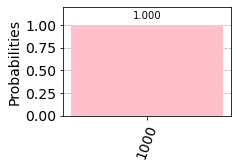

In [9]:
# Resultado de una funcion constante 0
results = execute(qc,Aer.get_backend('statevector_simulator'),shots=1000).result().get_counts()
plot_histogram(results, figsize=(3,2), color=['pink'])

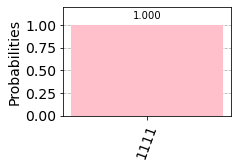

In [10]:
# Resultado de una funcion constante 1
qc = create_circuit('111')

results = execute(qc,Aer.get_backend('statevector_simulator'),shots=1000).result().get_counts()
plot_histogram(results, figsize=(3,2), color=['pink'])

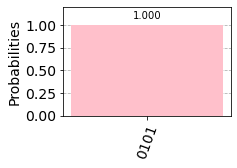

In [11]:
# Resultado de una funcion balanceada
qc = create_circuit('101')

results = execute(qc,Aer.get_backend('statevector_simulator'),shots=1000).result().get_counts()
plot_histogram(results, figsize=(3,2), color=['pink'])

Que tan costoso es aplicar la compuerta de tipo MCX?

In [16]:
qc2 = QuantumCircuit(qr, aux)

In [17]:
qr = QuantumRegister(TOSSES, "toss")
aux = QuantumRegister(1, "aux")
qc2.mcx(qr,aux)

In [18]:
qc2.draw()

toss_0: ──■──
          │  
toss_1: ──■──
          │  
toss_2: ──■──
        ┌─┴─┐
 aux_0: ┤ X ├
        └───┘

In [19]:
qc2_decomposed = qc2.decompose()

In [20]:
qc2_decomposed.draw()

┌────────┐                                                         »
toss_0: ┤ P(π/8) ├────■──────────────────■────────────────────■────────────»
        ├────────┤  ┌─┴─┐   ┌─────────┐┌─┴─┐                  │            »
toss_1: ┤ P(π/8) ├──┤ X ├───┤ P(-π/8) ├┤ X ├──■───────────────┼────────────»
        ├────────┤  └───┘   └─────────┘└───┘┌─┴─┐┌─────────┐┌─┴─┐┌────────┐»
toss_2: ┤ P(π/8) ├──────────────────────────┤ X ├┤ P(-π/8) ├┤ X ├┤ P(π/8) ├»
        └─┬───┬──┘┌────────┐                └───┘└─────────┘└───┘└────────┘»
 aux_0: ──┤ H ├───┤ P(π/8) ├───────────────────────────────────────────────»
          └───┘   └────────┘                                               »
«                                                                            »
«toss_0: ──────────────────■─────────────────────────────────────────────────»
«                          │                                                 »
«toss_1: ──■───────────────┼────────────────────■────────────────────────────»
«        ┌─┴─┐┌─────────┐┌─┴─┐                  │                            »
«toss_2: ┤ X ├┤ P(-π/8) ├┤ X ├──■───────────────┼──────────────■─────────────»
«        └───┘└─────────┘└───┘┌─┴─┐┌─────────┐┌─┴─┐┌────────┐┌─┴─┐┌─────────┐»
« aux_0: ─────────────────────┤ X ├┤ P(-π/8) ├┤ X ├┤ P(π/8) ├┤ X ├┤ P(-π/8) ├»
«                             └───┘└─────────┘└───┘└────────┘└───┘└─────────┘»
«                                                                           »
«toss_0: ──■─────────────────────────────────────────────────────────────■──»
«          │                                                             │  »
«toss_1: ──┼──────────────────────────────■──────────────────────────────┼──»
«          │                              │                              │  »
«toss_2: ──┼──────────────■───────────────┼──────────────■───────────────┼──»
«        ┌─┴─┐┌────────┐┌─┴─┐┌─────────┐┌─┴─┐┌────────┐┌─┴─┐┌─────────┐┌─┴─┐»
« aux_0: ┤ X ├┤ P(π/8) ├┤ X ├┤ P(-π/8) ├┤ X ├┤ P(π/8) ├┤ X ├┤ P(-π/8) ├┤ X ├»
«        └───┘└────────┘└───┘└─────────┘└───┘└────────┘└───┘└─────────┘└───┘»
«             
«toss_0: ─────
«             
«toss_1: ─────
«             
«toss_2: ─────
«        ┌───┐
« aux_0: ┤ H ├
«        └───┘